# Peer-graded Assignment: Анализ данных в задаче кредитного скоринга

In [120]:
import pandas as pd
import scipy.stats
import seaborn as sns
from scipy.stats import chi2_contingency

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Загружаем данные (из той же папки) и немного смотри на них

In [12]:
data = pd.read_csv("credit_card_default_analysis.csv")

In [13]:
data.head(2)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


In [8]:
data.isna().any()

ID           False
LIMIT_BAL    False
SEX          False
EDUCATION    False
MARRIAGE     False
AGE          False
PAY_0        False
PAY_2        False
PAY_3        False
PAY_4        False
PAY_5        False
PAY_6        False
BILL_AMT1    False
BILL_AMT2    False
BILL_AMT3    False
BILL_AMT4    False
BILL_AMT5    False
BILL_AMT6    False
PAY_AMT1     False
PAY_AMT2     False
PAY_AMT3     False
PAY_AMT4     False
PAY_AMT5     False
PAY_AMT6     False
default      False
dtype: bool

## Задание 1

In [21]:
data_limit_0 = data.loc[data.default == 0, "LIMIT_BAL"].values
data_limit_1 = data.loc[data.default == 1, "LIMIT_BAL"].values

Text(0, 0.5, 'Число наблюдений в определенном бине')

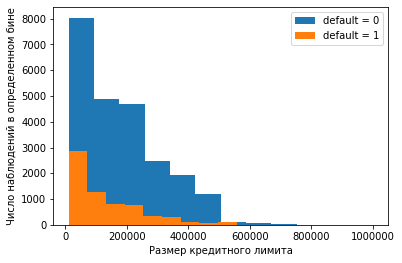

In [82]:
plt.hist(data_limit_0, label = "default = 0", bins = 12)
plt.hist(data_limit_1, label = "default = 1", bins = 12)
plt.legend()
plt.xlabel("Размер кредитного лимита")
plt.ylabel("Число наблюдений в определенном бине")

Мы видим, что наблюдений в дефолтной группе сильно меньше, но распределения двух величин похожи

Построим в логарифмированном масштабе

Text(0, 0.5, 'Логарифм числа наблюдений в определенном бине')

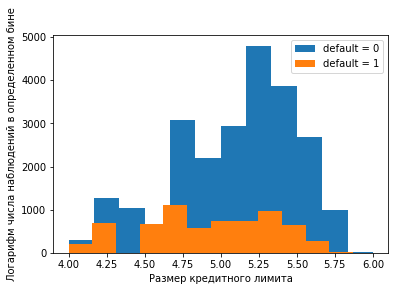

In [84]:
plt.hist(np.log10(data_limit_0), label = "default = 0", bins = 12)
plt.hist(np.log10(data_limit_1), label = "default = 1", bins = 12)
plt.legend()
plt.xlabel("Размер кредитного лимита")
plt.ylabel("Логарифм числа наблюдений в определенном бине")

##### Пункт a) проверим гипотезу о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки

Строить интервальные оценки будем с помощью __бутстрепа__

In [22]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [23]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [219]:
n = 1000
limit_0_bootstrap = list(map(np.median, get_bootstrap_samples(data_limit_0, 1000)))
limit_1_bootstrap = list(map(np.median, get_bootstrap_samples(data_limit_1, 1000)))

In [220]:
limit_0_intrvl = stat_intervals(limit_0_bootstrap, 0.05)
limit_1_intrvl = stat_intervals(limit_1_bootstrap, 0.05)

In [226]:
print(f'Интервальная оценка медианы кредитного лимита для клиентов с default = 0: {limit_0_intrvl}')
print(f'Интервальная оценка медианы кредитного лимита для клиентов с default = 1: {limit_1_intrvl}')

Интервальная оценка медианы кредитного лимита для клиентов с default = 0: [150000. 150000.]
Интервальная оценка медианы кредитного лимита для клиентов с default = 1: [80000. 90000.]


In [228]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(limit_1_intrvl, limit_0_intrvl)))
print(f'Интервальная оценка для разницы медианы кредитного лимита: {delta_median_scores}')

Интервальная оценка для разницы медианы кредитного лимита: [70000.0, 60000.0]


__Интервалы не пересекаются, нулевая гипотеза__ о равенстве медианных значений кредитного лимита 
__отвергается__

разница в десятки тысяч рублей - это практически значимая величина

##### Пункт б) проверим гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних

Подгружаем необходимые функции из уроков, __используем перестановочный криетерий__ для независимых выборок (люди в дефолтной и недефолтных группах - разные)

In [34]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [43]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [36]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [38]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [44]:
print(f'p-value: {permutation_test(data_limit_0, data_limit_1, max_permutations = 10000)}')

p-value: 0.0001


__Нулевая гипотеза__ о том, что средние значения кредитного лимита для людей, которые не вернули и вернули кредиты разные - __отвергается, с достигаемым уровнем значимости 0.0001__

## Задание 2

Готовим необходимые массивы

In [50]:
data.SEX.unique()

array([2, 1], dtype=int64)

In [51]:
gender_0 = data.loc[data.default == 0, "SEX"]
gender_1 = data.loc[data.default == 1, "SEX"]

Заменим цифру 2 обозначающую пол женщина на 0

In [52]:
gender_0 = gender_0.replace(2, 0)
gender_1 = gender_1.replace(2, 0)

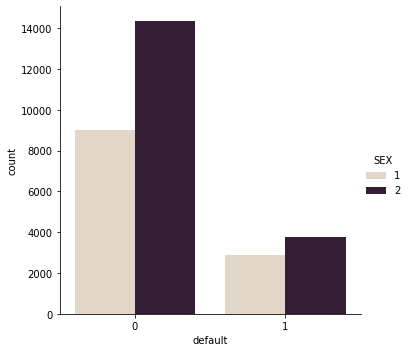

In [105]:
sns.catplot(x = 'default', kind="count", hue="SEX", palette="ch:.25", data=data)

Видим, что в дефолтной группе мужчин и женщин около одинаковое количество, а вот в недефолнтной - существено разное

##### Проверим гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. 

Подгружаем необходимые функции из уроков, используем интервалы для долей и z-критерий для долей

In [45]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [46]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [58]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

Считаем доверительный интервал для разности долей, с таким уровнем доверия, чтобы 0 входил внутрь интервала

In [68]:
proportions_diff_confint_ind(gender_0, gender_1, alpha = 5E-15)

(-0.10081063234929766, 0.006627621624772262)

К сожалению при дальнейшем уменьшении уровня доверия z не рассчитывается

In [70]:
alpha = 1E-16
z = scipy.stats.norm.ppf(1 - alpha / 2.)
z

inf

Но мы можем сделать вывод, что уровень значимости используя доверительные интервалы меньше, чем 5E-15, что нам достаточно,
чтобы отвергнуть нулевую гипотезу о равенстве долей полов в группах дефолтных и недефолтных 
клиентов

Посчитаем __теперь z критерий__ для двух независимых выборок

In [75]:
z_stat = proportions_diff_z_stat_ind(gender_0, gender_1)
p_val = proportions_diff_z_test(z_stat, alternative = 'two-sided')
print(f'Достигаемый уровень значимости: {p_val}')

Достигаемый уровень значимости: 4.472866521609831e-12


Мы с уверенностью отвергаем Нулевую гипотезу о том, что гендерный состав вернувших и не вернувших кредит не отличается

## 3 задание

##### Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг.

(в данном задании таблицы замещают визуалиции графиком)

In [175]:
data_crosstab = pd.crosstab([data.EDUCATION], data.default)
data_crosstab

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


Только в одной ячейке < 5 наблюдений - значит можно применять критерий Хи-квадрат о независимости выборок

In [137]:
### Считаем статистику Хи-квадрат
stat, p_value, dof, expected_crosstab = chi2_contingency(data_crosstab)

In [141]:
print(f'p_value = {p_value}')

p_value = 1.2332626245415605e-32


Нулевая гипотеза о том, что образование не влияет на то, вернет ли человек долг, отвергается

In [151]:
expected_crosstab = pd.DataFrame(data= expected_crosstab, columns=data_crosstab.columns, 
                                index = data_crosstab.index)

In [159]:
print(f'Таблица сопряженности ожидаемых значений: ')
expected_crosstab = expected_crosstab.round()
expected_crosstab

Таблица сопряженности ожидаемых значений: 


default,0,1
EDUCATION,,
0,11.0,3.0
1,8244.0,2341.0
2,10927.0,3103.0
3,3829.0,1088.0
4,96.0,27.0
5,218.0,62.0
6,40.0,11.0


Посчитаем таблицу сопряженности наблюдаемых значений минус ожидаемых:

In [160]:
diff_crosstab = data_crosstab - expected_crosstab
diff_crosstab

default,0,1
EDUCATION,,
0,3.0,-3.0
1,305.0,-305.0
2,-227.0,227.0
3,-149.0,149.0
4,20.0,-20.0
5,44.0,-44.0
6,3.0,-3.0


Т.к. ожидаемые значения получены в предположении независимости дефолта и образование, имеет смысл поделить разницу на ожидаемые значения и посчитать долю в процентах. Тогда мы увидим, какая именно категория образования ведёт себя наиболее "сильно"

In [180]:
diff_crosstab.iloc[:,0].div(expected_crosstab.iloc[:,0])*100

EDUCATION
0    27.272727
1     3.699660
2    -2.077423
3    -3.891355
4    20.833333
5    20.183486
6     7.500000
Name: 0, dtype: float64

__Оказывается, что это категория 0, то есть люди с докторской степенью__

### 4 задание

Проверим, как связан семейный статус с индикатором дефолта

In [184]:
dic_MARRIAGE = {0: 'отказываюсь отвечать', 1: 'замужем/женат', 2 : 'холост', 3 : 'нет данных'}

In [187]:
data.MARRIAGE.value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

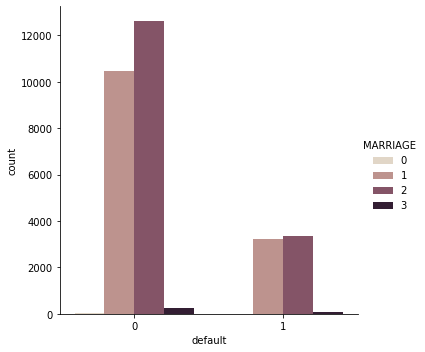

In [186]:
sns.catplot(x = 'default', kind="count", hue="MARRIAGE", palette="ch:.25", data=data)

Как и в прошлом задании посчитаем критерий Крамера, т.к. сравниваются у нас категориальная и бинарная величины

In [189]:
cross = pd.crosstab([data.MARRIAGE], data.default)
cross

default,0,1
MARRIAGE,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


In [190]:
### Считаем статистику Хи-квадрат
stat, p_value, dof, expected_cross = chi2_contingency(cross)

In [192]:
print(f'Значение статистики Хи-квадрат = {stat}')

Значение статистики Хи-квадрат = 35.66239583433609


Мерой является само значение статистики как квадрата отклонения от ожидаемых значений при нулевой гипотезе независимости типа семейного положения от дефолта

In [218]:
print(f'p_value = {p_value}')

p_value = 8.825862457577375e-08


Нулевая гипотеза о независимости уверенно отвергается

### 5 задание

Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?


Делаем то же самое, что и в 1 задании

In [194]:
data_age_0 = data.loc[data.default == 0, "AGE"].values
data_age_1 = data.loc[data.default == 1, "AGE"].values

Text(0, 0.5, 'Число наблюдений в определенном бине')

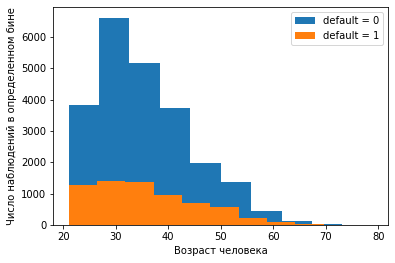

In [198]:
plt.hist(data_age_0, label = "default = 0", bins = 10)
plt.hist(data_age_1, label = "default = 1", bins = 10)
plt.legend()
plt.xlabel("Возраст человека")
plt.ylabel("Число наблюдений в определенном бине")

Видно, что распределения разные, у тех, кто возвращал кредит есть пик, а у тех, кто нет, до 35 лет - почти равномерное распределение

Проверим гипотезу о равенстве медианных значений возрастов людей с помощью бустрэпа

In [199]:
n = 1000
age_0_bootstrap = get_bootstrap_samples(data_age_0, n)
age_1_bootstrap = get_bootstrap_samples(data_age_1, n)

In [211]:
age_0_intrvl = stat_intervals(age_0_bootstrap, 0.05)
age_1_intrvl = stat_intervals(age_1_bootstrap, 0.05)

In [213]:
print(f'Интервальная оценка разницы медиан возрастов клиентов с default = 0: {age_0_intrvl}')
print(f'Интервальная оценка медианы возраста клиентов с default = 1: {age_1_intrvl}')

Интервальная оценка разницы медиан возрастов клиентов с default = 0: [23. 56.]
Интервальная оценка медианы возраста клиентов с default = 1: [22. 57.]


In [214]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(age_0_intrvl, age_1_intrvl)))
print(f'Интервальная оценка для разницы медианы возрастов: {delta_median_scores}')

Интервальная оценка для разницы медианы возрастов: [-1.0, 1.0]


Разницы почти нет => нет практической значимости

Проверим гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

Подгружаем необходимые функции из уроков, __используем перестановочный криетерий__ для независимых выборок (люди в дефолтной и недефолтных группах - разные)

In [216]:
print(f'p-value: {permutation_test(data_age_0, data_age_1, max_permutations = 10000)}')

p-value: 0.014


Гипотеза о независимости возраста и дефолта отвергается с достигаемым уровнем значимости 0.014